## Gini Index

The Gini Index is an error metric used while evaluating how splits should be made in a classification tree. This is defined as follows. If we wish to split a given region $R$ into two regions based on a predictor $X_j$ and a threshold value $s$ of that predictor, we would consider the regions $R_1 = \{X \vert X_j \leq s\}$ and $R_2 = \{X \vert X_j > s \}$, where $X = (X_1, \ldots, X_p)^T$. This split would be considered "good" if each of them contained training observations from predominantly one class. This goodness criterion is captured by the Gini index. For region $R_1$, the index is
$$
    \text{GI} = \sum_{k = 1}^{K} p_{1, k} (1 - p_{1, k}),
$$
where $K$ is the total number of classes and $p_{1, k}$ is the proportion of training observations in regsion $R_1$ from class $k$. The Gini index is small if one of the $p_{1, k} \approx 1$ while the others are $\approx 0$, which is precisely what we want.

## Cross-Entropy

The other alternative to the Gini index is to use cross-entropy, defined by:
$$
    D = - \sum_{k = 1}^{K} p_{1, k} \log p_{1, k}.
$$
This value is close to $0$ when one of the $p_{1, k} \approx 1$ while the others are close to $0$. Otherwise, the sum will be closer to $1$ as the following diagram depicts for the situation with just two classes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

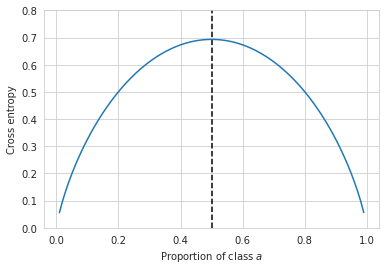

In [2]:
# Assume that there are two classes a and b. 
p_a = np.linspace(0.01, 0.99, num=100)
p_b = 1 - p_a

cross_entropy = [-x_a * np.log(x_a) -x_b * np.log(x_b) for x_a, x_b in zip(p_a, p_b)]

plt.xlabel(r'Proportion of class $a$')
plt.ylabel('Cross entropy')

plt.plot(p_a, cross_entropy)

plt.ylim(0, 0.8)
plt.vlines(x=0.5, ymin=-0.0, ymax=0.8, linestyle='--', color='k')

plt.show()

In [3]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    dot_data = StringIO()
    export_graphviz(estimator, 
                    out_file=dot_data, 
                    feature_names=features, 
                    class_names=class_names, 
                    filled=filled)
    
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    
    return graph 

In [4]:
HEART_DATA = '../datasets/Heart.csv'
df = pd.read_csv(HEART_DATA)

df.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [5]:
df.isna().any()

Unnamed: 0    False
Age           False
Sex           False
ChestPain     False
RestBP        False
Chol          False
Fbs           False
RestECG       False
MaxHR         False
ExAng         False
Oldpeak       False
Slope         False
Ca             True
Thal           True
AHD           False
dtype: bool

In [6]:
df = df.dropna()
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        297 non-null    int64  
 1   Sex        297 non-null    int64  
 2   ChestPain  297 non-null    object 
 3   RestBP     297 non-null    int64  
 4   Chol       297 non-null    int64  
 5   Fbs        297 non-null    int64  
 6   RestECG    297 non-null    int64  
 7   MaxHR      297 non-null    int64  
 8   ExAng      297 non-null    int64  
 9   Oldpeak    297 non-null    float64
 10  Slope      297 non-null    int64  
 11  Ca         297 non-null    float64
 12  Thal       297 non-null    object 
 13  AHD        297 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


## Factorize Categorical Variables

In [7]:
CATEGORICAL = ['ChestPain', 'Thal', 'AHD']

# pd.factorize returns the code, uniques (the unique values of the categorical variable)
for cat in CATEGORICAL:
    df[cat] = pd.factorize(df[cat])[0]

In [8]:
df['AHD'].head()

0    0
1    1
2    1
3    0
4    0
Name: AHD, dtype: int64

## Create Classifier

In [9]:
import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from six import StringIO  
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [10]:
X = df.drop('AHD', axis=1)
y = df['AHD']

clf = DecisionTreeClassifier(max_depth=6, max_leaf_nodes=20, max_features=5, min_impurity_decrease=0.001)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=6, max_features=5, max_leaf_nodes=20,
                       min_impurity_decrease=0.001)

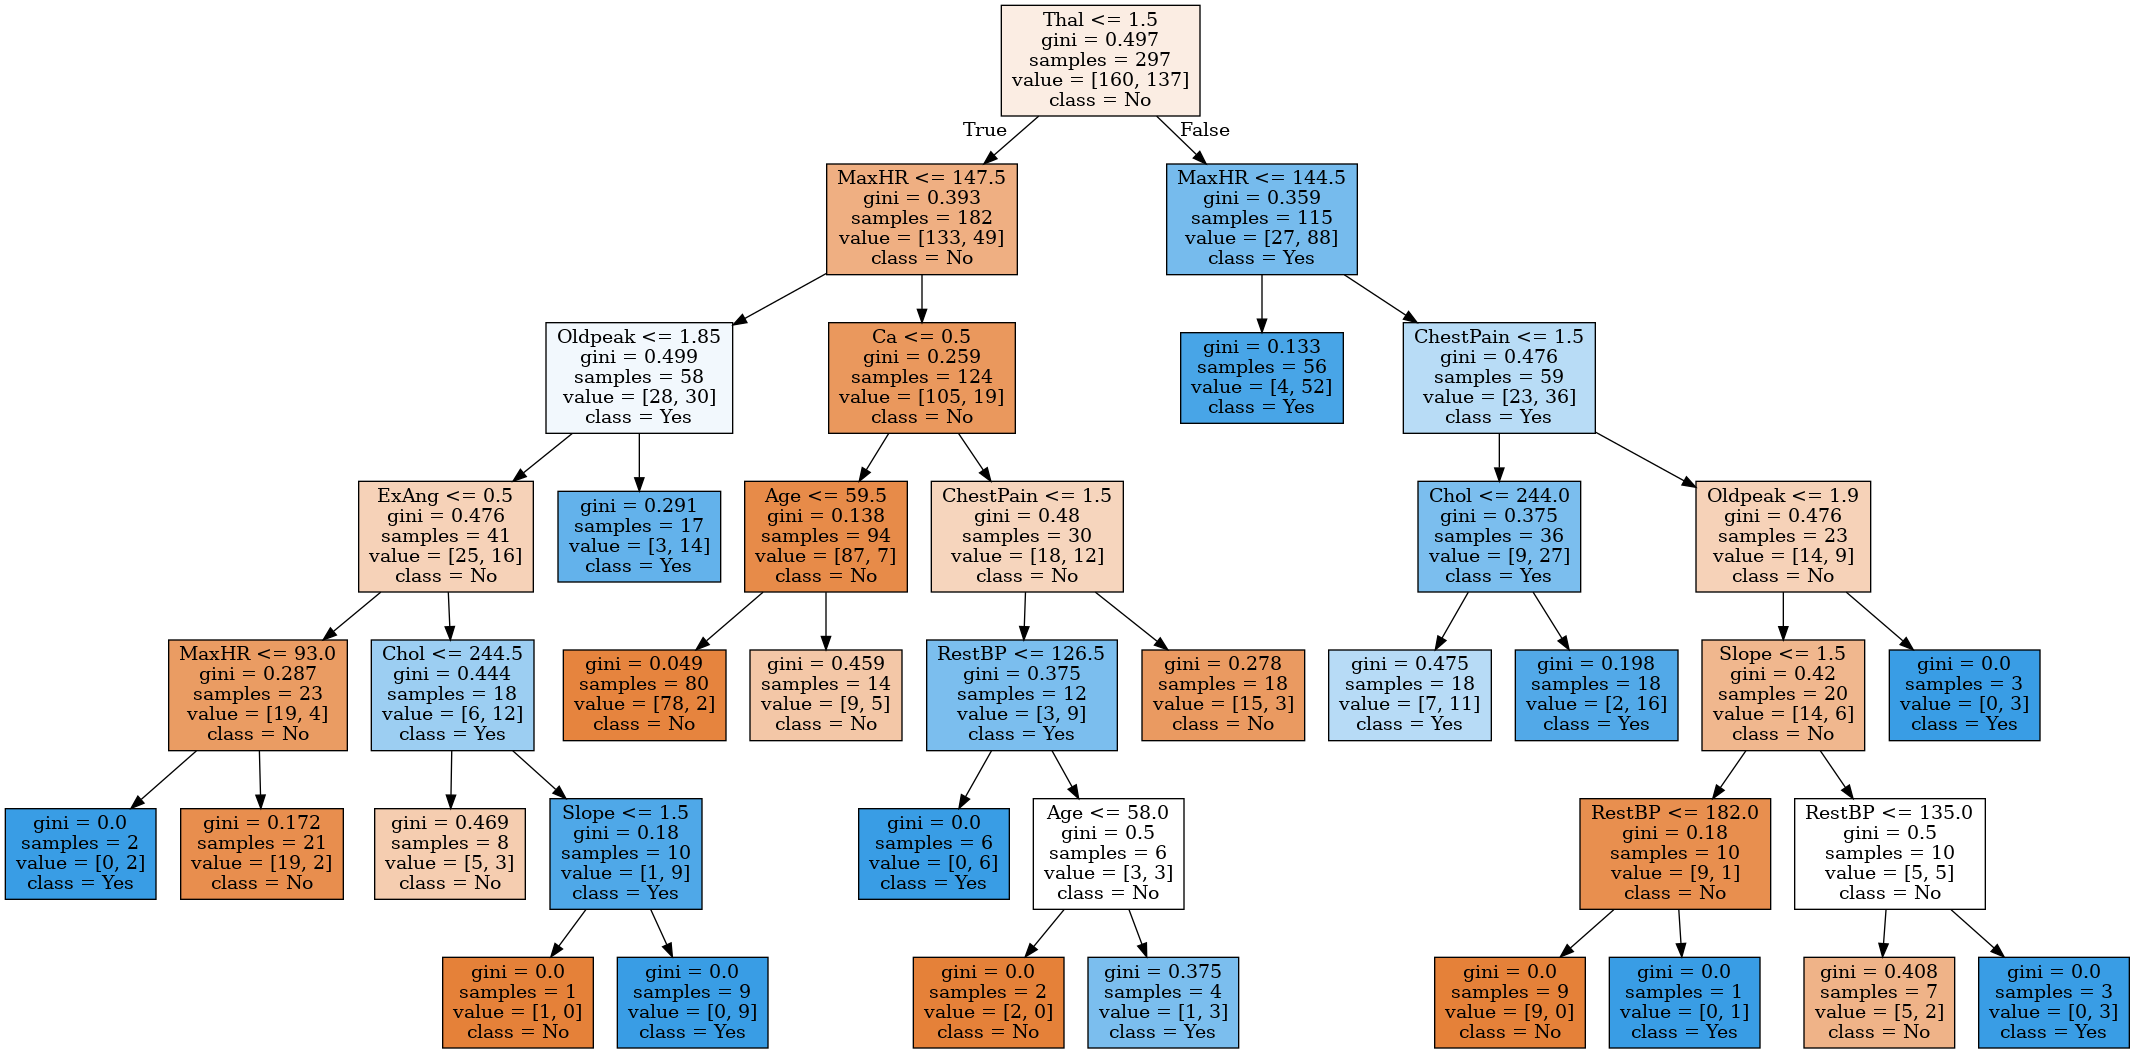

In [11]:
graph = print_tree(clf, X.columns, class_names=['No', 'Yes'])

Image(graph[0].create_png())

## Pruning the Classification Tree

In [12]:
df.shape

(297, 14)

In [13]:
df_train = df.sample(200, random_state=0)
df_test = df[~df.index.isin(df_train.index)]

X_train, y_train = df_train.drop('AHD', axis=1), df_train['AHD']
X_test, y_test = df_test.drop('AHD', axis=1), df_test['AHD']

In [14]:
clf_2 = DecisionTreeClassifier(random_state=0)
path = clf_2.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [15]:
clfs = []
node_counts = []
depth = []


for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    
    clfs.append(clf)
    node_counts.append(clf.tree_.node_count)
    depth.append(clf.tree_.max_depth)
    

print(f'The number of nodes in last tree = {node_counts[-1]}, ccp_alpha: {ccp_alphas[-1]}')

The number of nodes in last tree = 1, ccp_alpha: 0.14154096880131367


In [16]:
# Remove the last entry, since this tree has just one node

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = node_counts[:-1]
depth = depth[:-1]

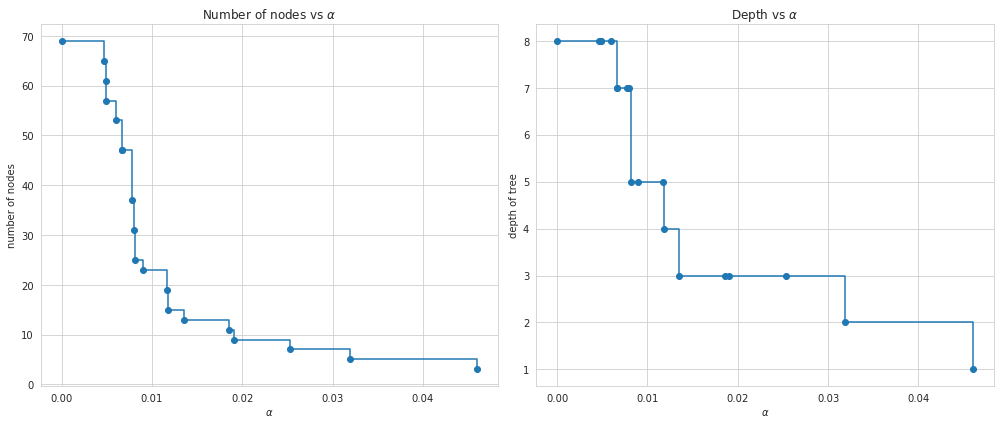

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel("number of nodes")
ax[0].set_title(r"Number of nodes vs $\alpha$")

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_ylabel("depth of tree")
ax[1].set_title(r"Depth vs $\alpha$")

fig.tight_layout()

## Accuracy vs $\alpha$ 

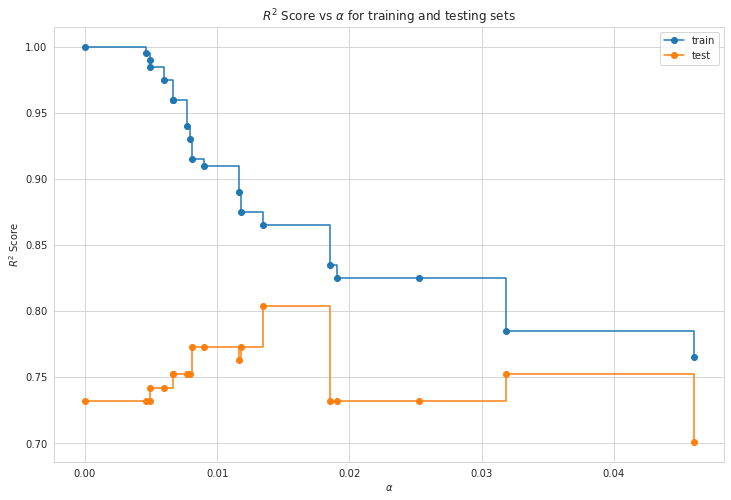

In [18]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$R^2$ Score")
ax.set_title(r"$R^2$ Score vs $\alpha$ for training and testing sets")

ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")

ax.legend()

plt.show()

## Accuracy vs Number of Nodes

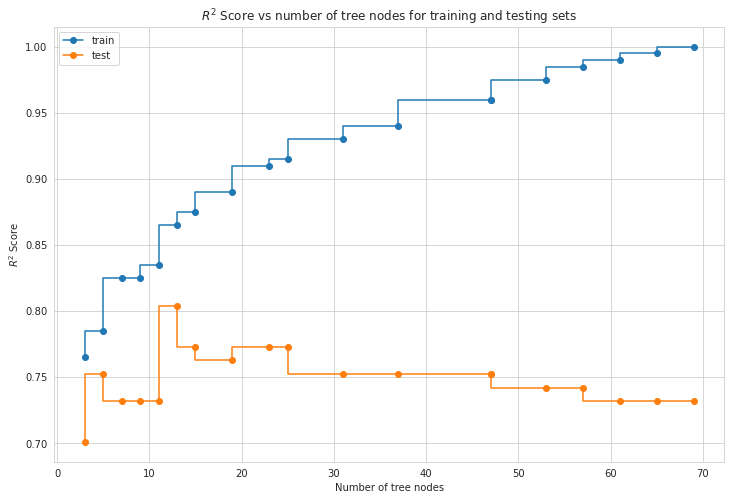

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.set_xlabel(r"Number of tree nodes")
ax.set_ylabel(r"$R^2$ Score")
ax.set_title(r"$R^2$ Score vs number of tree nodes for training and testing sets")

ax.plot(node_counts, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(node_counts, test_scores, marker='o', label="test", drawstyle="steps-post")

ax.legend()

plt.show()

## Best Tree (with Highest Test $R^2$)

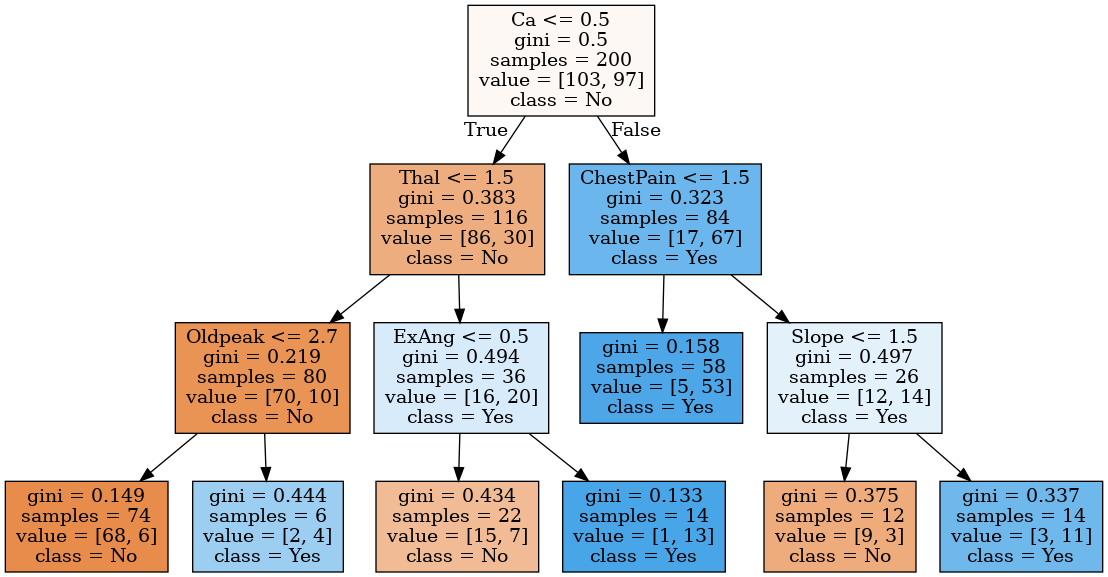

In [20]:
idx = np.argmax(test_scores)

best_clf = clfs[idx]
best_graph = print_tree(best_clf, X.columns, class_names=['No', 'Yes'])

Image(best_graph[0].create_png())

## Feature Importance by Bagging

__From the Docs__ (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In this context, one can use an error estimation technique called the _out-of-bag_ error estimation. This is based on the observation that if we use bootstrapped subsets to fit decision trees, then each tree on an average uses only $2/3$ of the observations of the original sample. This can be seen as follows: let $\{(x_1, y_1), \ldots, (x_n, y_n)\}$ be the original sample. Consider a bootstrapped subset obtained by choosing $n$ observations from this sample uniformly at random without replacement. The probability that a given observation, say $(x_1, y_1)$, is _not_ in this bootstrapped sample is $(1 - \frac{1}{n})^n \approx e^{-1}$. Thus the expected number of elements that are _not_ in the bootstrapped subset = $n \cdot (1 - \frac{1}{n})^n \approx n \cdot e^{-1} =  0.367 n$. 

Thus an estimate of the test error can be made as follows. Suppose we use $B$ bootstrapped subsets to construct $B$ trees. Then for each observation $(x_i, y_i)$, there are on average $B/3$ trees that are constructed _not_ using it. This observation is said to be _out-of-bag_ for these trees. We can estimate the error of this observation on these trees. We repeat this for every observation in the original sample and then take the mean error over all observations.   

In [21]:
from sklearn.ensemble import BaggingClassifier


X = df.drop('AHD', axis=1)
y = df['AHD']

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), 
                        n_estimators=1000, 
                        max_samples=len(X), 
                        max_features=len(X.columns), 
                        oob_score=True, 
                        n_jobs=4)
clf.fit(X, y)

feature_importances = np.mean([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [22]:
df_features = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
df_features.sort_values('importance', ascending=False).head()

,feature,importance
11,Ca,0.172711
12,Thal,0.147420
7,MaxHR,0.112226
2,ChestPain,0.111972
9,Oldpeak,0.104895


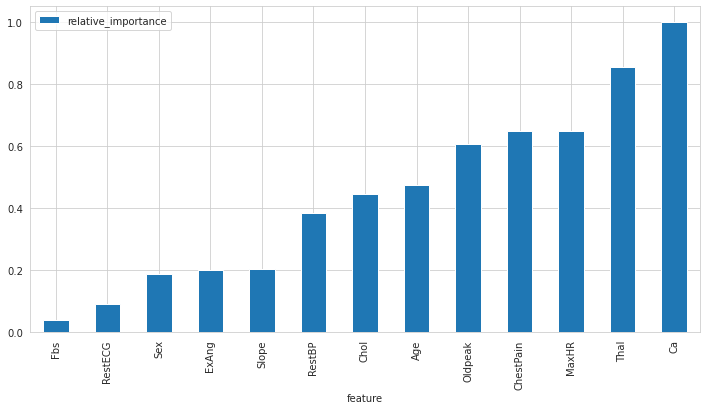

In [23]:
df_features['relative_importance'] = df_features['importance'] / df_features['importance'].max()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_features.sort_values('relative_importance').plot.bar(x='feature', y='relative_importance', ax=ax)

plt.show()